Importing required libraries

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


Here we define a function that opens the gzip file, reads the file using bytestream.read(). 
We pass the image dimension and the total number of images to this function. 
Then, using np.frombuffer(), we convert the string stored in variable buf into a NumPy array of type float32.
Next, we reshape the array into a three-dimensional array or tensor where the first dimension is number of images, and the second and third dimension being the dimension of the image. 
Finally, we return the NumPy array data.

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

Similarly, we define a extract labels function that opens the gzip file, reads the file using bytestream.read(), to which we pass the label dimension (1) and the total number of images. 
Then, using np.frombuffer(), we convert the string stored in variable buf into a NumPy array of type int64.
This time, we do not need to reshape the array since the variable labels will return a column vector of dimension 60,000 x 1. Finally, we return the NumPy array labels.

In [3]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

Loading the Data:
The notMNIST dataset is an image recognition dataset of font glypyhs for the letters A through J. 
It is quite similar to the classic MNIST dataset, which contains images of handwritten digits 0 through 9: in this case, 
we'll find that the NotMNIST dataset comprises 28x28 grayscale images of 70,000 letters from A - J in total 10 categories, and 6,000 images per category.

In [4]:
train_data = extract_data('C:/Users/prateek1.gupta/Downloads/notMNIST-to-MNIST-master/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('C:/Users/prateek1.gupta/Downloads/notMNIST-to-MNIST-master/t10k-images-idx3-ubyte.gz', 10000)

We will now call the function extract label by passing the training and testing label files along with their corresponding number of images:

In [5]:
train_labels = extract_labels('C:/Users/prateek1.gupta/Downloads/notMNIST-to-MNIST-master/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('C:/Users/prateek1.gupta/Downloads/notMNIST-to-MNIST-master/t10k-labels-idx1-ubyte.gz',10000)

Data Exploration:
Let's now analyze how images in the dataset look like and also see the dimension of the images with the help of the NumPy array attribute .shape:

In [6]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


From the above output, we can see that the training data has a shape of 60000 x 28 x 28 since there are 60,000 training samples each of 28 x 28 dimensional matrix. 
Similarly, the test data has a shape of 10000 x 28 x 28 since there are 10,000 testing samples.

Note that in this task:
We will not be using the training and testing labels. 
The task at hand will only be dealing with the training and testing images. 
However, for exploration purposes, which might give us a better intuition about the data, we'll make use the labels.

Let's create a dictionary that will have class names with their corresponding categorical class labels:

In [7]:
# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

Now, let's take a look at couple of the images in our dataset:

Text(0.5,1,'(Label: D)')

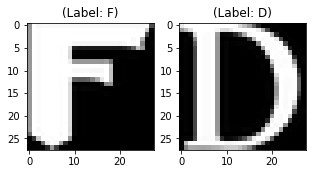

In [8]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

The output of above two plots are one of the sample images from both training and testing data, and these images are assigned a class label of 5 or F, on the one hand, and 3 or D, on the other hand. 
Similarly, other alphabets will have different labels, but similar alphabets will have same labels. 
This means that all the 6,000 class F images will have a class label of 5.

Data Preprocessing:
The images of the dataset are indeed grayscale images with pixel values ranging from 0 to 255 with a dimension of 28 x 28 so before we feed the data into the model it is very important to preprocess it. 
We'll first convert each 28 x 28 image of train and test set into a matrix of size 28 x 28 x 1, which we can feed into the network.

In [9]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Next, we want to make sure to check the data type of the training and testing NumPy arrays, it should be in float32 format, 
if not we will need to convert it into this format, but since we already have converted it while reading the data you no longer need to do this again. 
We also have to rescale the pixel values in range 0 - 1 inclusive. So let's do that!

Don't forget to verify the training and testing data types:

In [10]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

Next, rescale the training and testing data with the maximum pixel value of the training and testing data:

In [11]:
np.max(train_data), np.max(test_data)

(255.0, 255.0)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

Let's verify the maximum value of training and testing data which should be 1.0 after rescaling it!

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

After all of this, it's important to partition the data. 
In order for our model to generalize well, we split the training data into two parts: a training and a validation set. 
We will train our model on 80% of the data and validate it on 20% of the remaining training data.

This will also help us in reducing the chances of overfitting, as we will be validating your model on data it would not have seen in training phase.

We can use the train_test_split module of scikit-learn to divide the data properly:

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

Note that for this task, we don't need training and testing labels. 
That's why we will pass the training images twice. 
our training images will both act as the input as well as the ground truth similar to the labels we have in classification task.

Now we are all set to define the network and feed the data into the network. 
So without any further ado, let's jump to the next step!

The Convolutional Autoencoder:
The images are of size 28 x 28 x 1 or a 784-dimensional vector. We convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 28 x 28 x 1, and feed this as an input to the network.

Also, we will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable it all depends on the system we train your model. 
It contributes heavily in determining the learning parameters and affects the prediction accuracy. We will train your network for 50 epochs.

In [15]:
batch_size = 128
epochs = 50
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

Encoder

The first layer will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,
The second layer will have 64 filters of size 3 x 3, followed by another downsampling layer,
The final layer of encoder will have 128 filters of size 3 x 3.


Decoder
The first layer will have 128 filters of size 3 x 3 followed by a upsampling layer,/li>
The second layer will have 64 filters of size 3 x 3 followed by another upsampling layer,
The final layer of encoder will have 1 filter of size 3 x 3.

Note: The number of filters, the filter size, the number of layers, number of epochs we train your model, are all hyperparameters and should be decided based on our own intuition, we are free to try new experiments by tweaking with these hyperparameters and measure the performance of our model.
And that is how we will slowly learn the art of deep learning!

In [16]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

After the model is created, we have to compile it using the optimizer to be RMSProp.

Note that we also have to specify the loss type via the argument loss. 
In this case, that's the mean squared error, since the loss after every batch will be computed between the batch of predicted output and the ground truth using mean squared error pixel by pixel:

In [17]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Let's visualize the layers that we created in the above step by using the summary function, this will show number of parameters (weights and biases) in each layer and also the total parameters in your model.

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         147584    
__________

It's finally time to train the model with Keras' fit() function! 
The model trains for 50 epochs. The fit() function will return a history object; By storying the result of this function in fashion_train, we can use it later to plot the loss function plot between training and validation which will help us to analyze your model's performance visually.

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 786s 16ms/step - loss: 0.0360 - val_loss: 0.0125
Epoch 2/50
48000/48000 [==============================] - 818s 17ms/step - loss: 0.0109 - val_loss: 0.0086
Epoch 3/50
48000/48000 [==============================] - 869s 18ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 4/50
48000/48000 [==============================] - 867s 18ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 5/50
48000/48000 [==============================] - 871s 18ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 6/50
48000/48000 [==============================] - 867s 18ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 7/50
48000/48000 [==============================] - 859s 18ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 8/50
48000/48000 [==============================] - 841s 18ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 9/50
48000/48000 [==============================] - 437s 9ms/step - loss: 0.0039 - val_l

Finally! We trained the model on Not-MNIST for 50 epochs, Now, let's plot the loss plot between training and validation data to visualise the model performance.

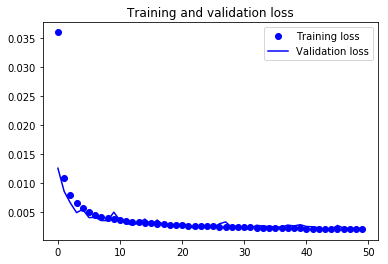

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Finally, you can see that the validation loss and the training loss both are in sync. 
It shows that our model is not overfitting: the validation loss is decreasing and not increasing, and there rarely any gap between training and validation loss.

Therefore, you can say that our model's generalization capability is good.

Finally, it's time to reconstruct the test images using the predict() function of Keras and see how well our model is able reconstruct on the test data.

We will be predicting the trained model on the complete 10,000 test images and plot few of the reconstructed images to visualize how well our model is able to reconstruct the test images.

In [21]:
pred = autoencoder.predict(test_data)

In [22]:
pred.shape

(10000, 28, 28, 1)

Test Images


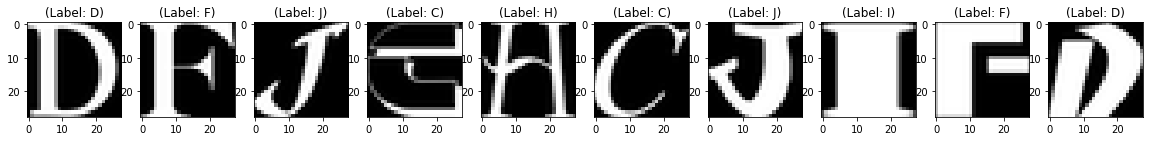

Reconstruction of Test Images


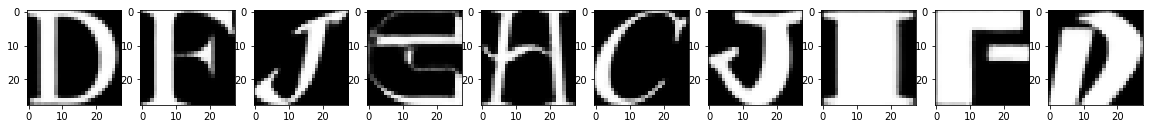

In [23]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

From the above figures, you can observe that our model did a fantastic job in reconstructing the test images that we predicted using the model. At least visually speaking, the test and the reconstructed images look almost exactly similar.

Denoising Autoencoder
A denoising autoencoder tries to learn a representation (latent-space or bottleneck) that is robust to noise. You add noise to an image and then feed the noisy image as an input to the enooder part of your network. The encoder part of the autoencoder transforms the image into a different space that tries to preserve the alphabets but removes the noise.

But how does it exactly remove the noise?

During training, you define a loss function, similar to the root mean squared error that you had defined earlier in convolutional autoencoder. At every iteration of the training, the network will compute a loss between the noisy image outputted by the decoder and the ground truth (denoisy image) and will also try to minimize that loss or difference between the reconstructed image and the original noise-free image. In other words, the network will learn a 7 x 7 x 128 space that will be noise free encodings of the data that you will train your network on!

Implementation of Denoising Autoencoder
Now, to see how this works in Python, you will be using the same NotMNIST dataset as you did in the first part of this tutorial. That means you need not do any data preprocessing since it has already been done before! However, one important preprocessing step in this part of the tutorial will be adding noise to the training, validation and testing images. So, let's quickly do that first!


Adding Noise to Images
Let's first define a noise factor which is a hyperparameter. The noise factor is multiplied with a random matrix that has a mean of 0.0 and standard deviation of 1.0. This matrix will draw samples from normal (Gaussian) distribution. The shape of the random normal array will be similar to the shape of the data you will be adding the noise.

For simplicity, let's understand it with an example: The variable train_X has a shape of 48000 x 28 x 28 x 1. Hence, the random normal array will also have a shape similar to train_X only then you will be able to add two arrays since then they will have same dimensions.

In [24]:
noise_factor = 0.5
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

np.clip() will threshold all the negative values to zero and all the values greater than one to one. Since, you want your pixel values to be between zero and one. And there are chances that after introducing noise into the data the pixel values range can change a bit, so to be on the safer side it's a good practice to clip the pixel values.

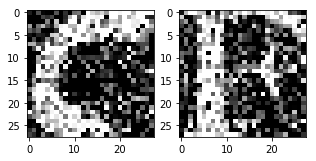

In [25]:
#Visualizing the noisy images
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

Now that you have the noisy data, you can feed it into the network and see how the noise is "magically" removed from the images!


Denoising Autoencoder Network
As discussed before the autoencoder is divided into two parts: the encoder and the decoder. The architecture that you're going to construct will look like the following:

Encoder

The first layer will have 32-3 x 3 filters followed by a downsampling (max-pooling) layer,
The second layer will have 64-3 x 3 filters followed by another downsampling layer,
The final layer of encoder will have 128-3 x 3 filters.


Decoder
The first layer will have 128-3 x 3 filters followed by a upsampling layer,
The second layer will have 64-3 x 3 filters followed by another upsampling layer,
The final layer of encoder will have 1-3 x 3 filters.

In [26]:
batch_size = 128
epochs = 20
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [27]:
def autoencoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

In [28]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Training
If you remember while training the convolutional autoencoder, you had fed the training images twice since the input and the ground truth were both same. However, in denoising autoencoder, you feed the noisy images as an input while your ground truth remains the denoisy images on which you had applied the noise. Only then the network will be able to compute a loss between the noisy and the true denoisy images.

In [29]:
autoencoder_train = autoencoder.fit(x_train_noisy, train_X, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid_noisy, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 436s 9ms/step - loss: 0.0583 - val_loss: 0.0324
Epoch 2/20
48000/48000 [==============================] - 605s 13ms/step - loss: 0.0284 - val_loss: 0.0251
Epoch 3/20
48000/48000 [==============================] - 873s 18ms/step - loss: 0.0239 - val_loss: 0.0214
Epoch 4/20
48000/48000 [==============================] - 874s 18ms/step - loss: 0.0216 - val_loss: 0.0206
Epoch 5/20
48000/48000 [==============================] - 871s 18ms/step - loss: 0.0201 - val_loss: 0.0184
Epoch 6/20
48000/48000 [==============================] - 875s 18ms/step - loss: 0.0191 - val_loss: 0.0178
Epoch 7/20
48000/48000 [==============================] - 705s 15ms/step - loss: 0.0183 - val_loss: 0.0180
Epoch 8/20
48000/48000 [==============================] - 433s 9ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 9/20
48000/48000 [==============================] - 433s 9ms/step - loss: 0.0174 - val_los

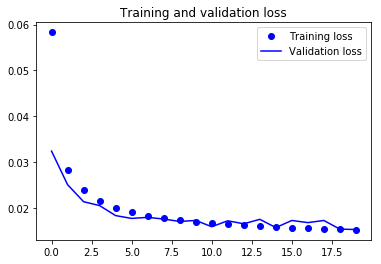

In [30]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above plot, you can derive some intuition that the model is overfitting at some epochs while being in sync for most of the time. You can definitely try to improve the performance of the model by introducing some complexity into it so that the loss can reduce more, try training it for more epochs and then decide.

In [31]:
#Predicting on Test dataset
pred = autoencoder.predict(x_test_noisy)

Test Images


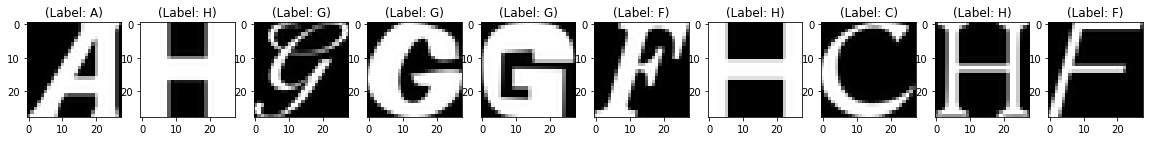

Test Images with Noise


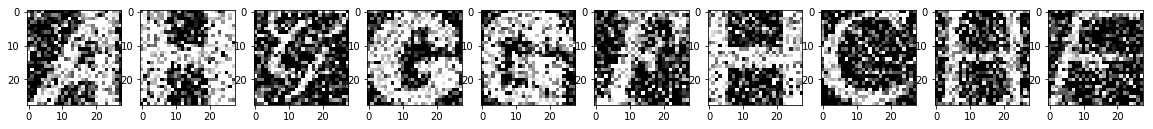

Reconstruction of Noisy Test Images


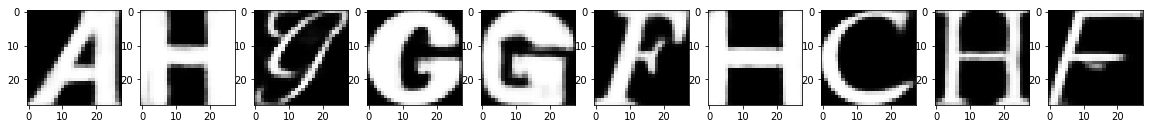

In [32]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_data[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Test Images with Noise")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    

plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(10,20,1):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

It looks like that, within just 20 epochs, a fairly simple network architecture did a pretty good job in removing the noise from the test images, isn't it?